In [17]:
import sys 
sys.path.append('../helper')
import pandas as pd

In [20]:
nrows = 1000
points = pd.read_csv("../data/rotated_points.csv", nrows=nrows)

In [21]:
points.head()

,x1,y1,x2,y2
0,-0.545621,0.838032,-0.978391,0.206765
1,0.664113,-0.747632,0.998255,-0.059057
2,0.627280,-0.778793,0.994244,-0.107136
3,0.886203,-0.463297,0.954241,0.299039
4,-0.999402,-0.034592,-0.682224,-0.731144


# Training

In [22]:
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import RotationMatrix
seed = 234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [23]:
X = torch.DoubleTensor(points[["x1", "y1"]].values)
y = torch.DoubleTensor(points[["x2", "y2"]].values)
train_data = TensorDataset(X, y)
train_loader = lambda batch_size: DataLoader(train_data, batch_size=batch_size, shuffle=False)

In [24]:
def l2_loss(y_pred, y_true, rotation_matrix):
    error = y_pred - y_true
    return sum([sum([e ** 2 for e in error_vec]) for error_vec in error]) / len(error)

In [25]:
def det_loss(y_pred, y_true, rotation_matrix):
    det = rotation_matrix[0][0] * rotation_matrix[1][1] - rotation_matrix[0][1] * rotation_matrix[1][0]
    return (det - 1) ** 2

In [26]:
def norm_loss(y_pred, y_true, rotation_matrix):
    avg_norm = sum([pred.norm() for pred in y_pred]) / len(y_pred)
    return (avg_norm - 1) ** 2

In [27]:
# first weight is for l2_loss, second weight for det_loss, third for norm loss
def get_mixed_lossfn(weigths):
    def mixed_loss(y_pred, y_true, rotation_matrix):
        l0 = l2_loss(y_pred, y_true, rotation_matrix)
        l1 = det_loss(y_pred, y_true, rotation_matrix)
        l2 = norm_loss(y_pred, y_true, rotation_matrix)
        return weigths[0] * l0 + weigths[1] * l1 + weigths[2] * l2
    return mixed_loss

In [28]:
true_rotation_matrix = torch.tensor(RotationMatrix.get_matrix(), dtype=torch.float64)

# returns the norm of the difference of the matrix to the true rotation matrix
def matrix_loss(rotation_matrix):
    return (rotation_matrix - true_rotation_matrix).norm()

In [29]:
rotation_matrix_start = torch.randn(2, 2, dtype=torch.float64)
new_rotation_matrix = lambda: Variable(rotation_matrix_start.clone(), requires_grad=True)

In [30]:
is_double_zero = lambda x: abs(x) < 1e-31

In [31]:
def train(params, debug=False, include_rotation_matrices=False, include_grads=False):
    losses = []
    gradients = []
    rotation_matrices = []
    rotation_matrix = new_rotation_matrix()
    optimizer = None
    if params["opt"] == "Adam":
        optimizer = Adam([rotation_matrix], lr=params["lr"])
    elif params["opt"] == "SGD":
        optimizer = SGD([rotation_matrix], lr=params["lr"])
    for x_batch, y_batch in train_loader(params["batch_size"]):
        pred = torch.mm(x_batch, rotation_matrix.transpose(0, 1))
        error = pred - y_batch
        loss = params["lossfn"](pred, y_batch, rotation_matrix)
        if is_double_zero(loss):
            loss *= 0
        optimizer.zero_grad()
        loss.backward()
        if debug:
            print("------------------------------------")
            print("Loss = {}".format(loss.item()))
            print("Current matrix:")
            print(rotation_matrix.data.numpy())
            print("True matrix:")
            print(true_rotation_matrix.data.numpy())
            print("Gradient:")
            print(rotation_matrix.grad)
        if include_grads:
            gradients.append(rotation_matrix.grad.numpy().copy())
        if include_rotation_matrices:
            rotation_matrices.append(rotation_matrix.detach().numpy().copy())
        optimizer.step()
        losses.append(matrix_loss(rotation_matrix).data.item())
    return {"loss": losses, "rotation_matrices": rotation_matrices, "grads": gradients}

In [32]:
def compare_params(paramsets):
    for paramset in paramsets:
        result = train(paramset)
        matrix_loss = result["loss"]
        paramset_copy = paramset.copy()
        paramset_copy["lossfn"] = paramset_copy["lossfn"].__name__
        label = str(paramset_copy)
        plt.plot(range(0, nrows, paramset["batch_size"]), matrix_loss, label=label)
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(1.04,1), loc='best')
    plt.show()

In [33]:
def compare_gradients(paramsets):
    results = [train(paramset, include_rotation_matrices=True, include_grads=True) for paramset in paramsets]    
    for i in range(len(results[0]["grads"])):
        print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
        for res in results:
            print("True gradient:")
            print(res["rotation_matrices"][i] - true_rotation_matrix.numpy())
            print("Gradient:")
            print(res["grads"][i])
            print("Current model:")
            print(res["rotation_matrices"][i])
            print("---------")

## Finding a baseline

In [34]:
learning_rates = [1e-0, 1e-1, 1e-2, 1e-3]
optimizers = ["Adam", "SGD"]
batch_sizes = [1, 10]
lossfns = [l2_loss]
paramsets_baseline = [{"lossfn": lossfn, "opt": opt, "lr": lr, "batch_size": batch_size} for lossfn in lossfns for opt in optimizers for lr in learning_rates for batch_size in batch_sizes]
filtered_paramsets = [
    {"lossfn": l2_loss, 'opt': 'Adam', 'lr': 0.1, 'batch_size': 1},
    {"lossfn": l2_loss, 'opt': 'SGD', 'lr': 0.1, 'batch_size': 1},
    {"lossfn": l2_loss, 'opt': 'SGD', 'lr': 1.0, 'batch_size': 10},
]
paramsets_baseline = filtered_paramsets

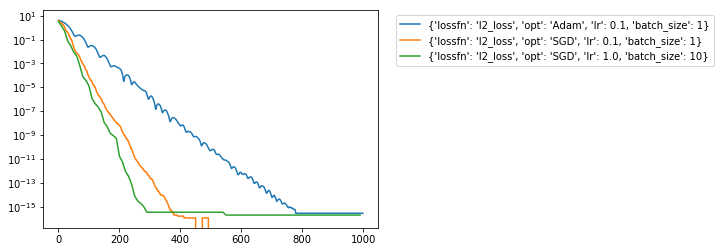

In [35]:
compare_params(paramsets_baseline)

In [36]:
baseline_params = paramsets_baseline[-1]
baseline_params

{'batch_size': 10,
 'lossfn': <function __main__.l2_loss>,
 'lr': 1.0,
 'opt': 'SGD'}

## Add determinant loss

In [37]:
weights = [(1, 0, 0), (1, 0.1, 0)]
paramsets = []
for weight_pair in weights:
    new_paramset = baseline_params.copy()
    new_paramset["lossfn"] = get_mixed_lossfn(weight_pair)
    paramsets.append(new_paramset)

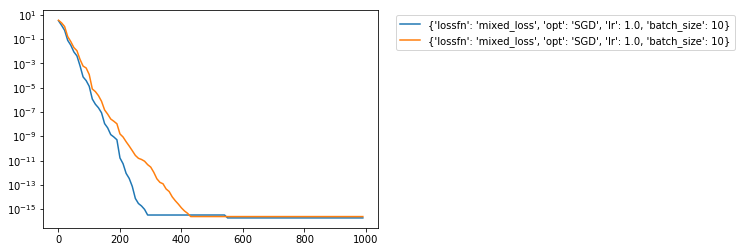

In [38]:
compare_params(paramsets)

Result: Minimal to no improvement
TODO: Perhaps predictions are more consistent?

## Add norm loss

In [41]:
weights = [(1, 0, 0), (1, 0, 0.1)]
paramsets = []
for weight_pair in weights:
    new_paramset = baseline_params.copy()
    new_paramset["lossfn"] = get_mixed_lossfn(weight_pair)
    paramsets.append(new_paramset)

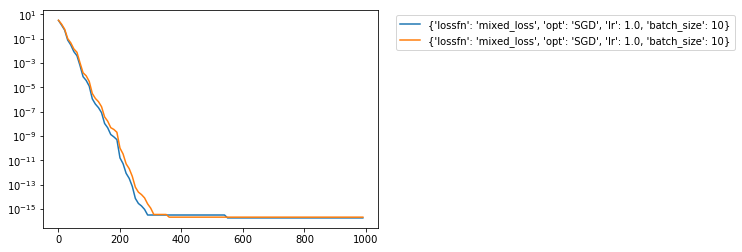

In [42]:
compare_params(paramsets)

Result: No improvement -> norm is already included in supervised error, direction to correct point is better than direction to normalized prediction

# Check how much can be learned using only few points

In [4]:
rotation_matrix = new_rotation_matrix()
opt = Adam([rotation_matrix])
n_train = 1
s_X = torch.DoubleTensor(points[["x1", "y1"]].values[:n_train])
s_y = torch.DoubleTensor(points[["x2", "y2"]].values[:n_train])
s_train_data = TensorDataset(s_X, s_y)
s_train_loader = DataLoader(s_train_data, shuffle=False)
loss_curve = []
for epoch in range(10000):
    for x_batch, y_batch in s_train_loader:
        pred = torch.mm(x_batch, rotation_matrix.transpose(0, 1))
        error = pred - y_batch
        loss = l2_loss(pred, y_batch, rotation_matrix)
        if is_double_zero(loss):
            loss *= 0
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_curve.append(matrix_loss(rotation_matrix))
plt.plot(loss_curve)
# plt.yscale("log")
plt.show()

NameError: name 'new_rotation_matrix' is not defined

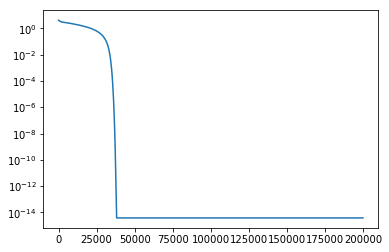

In [53]:
plt.plot(loss_curve)
plt.yscale("log")
plt.show()

Result: 1 point converges to wrong matrix, 2 points converge to truth